<a href="https://colab.research.google.com/github/ue20yqkw/Inverse-Kinematics/blob/main/Satellite_dock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode 1/500, Reward: -9.06, Epsilon: 1.00
Episode 2/500, Reward: -15.63, Epsilon: 1.00
Episode 3/500, Reward: -23.61, Epsilon: 1.00
Episode 4/500, Reward: -11.18, Epsilon: 0.99
Episode 5/500, Reward: -17.08, Epsilon: 0.99
Episode 6/500, Reward: -11.53, Epsilon: 0.99
Episode 7/500, Reward: -21.96, Epsilon: 0.98
Episode 8/500, Reward: -16.57, Epsilon: 0.98
Episode 9/500, Reward: -8.83, Epsilon: 0.97
Episode 10/500, Reward: 6.06, Epsilon: 0.97
Episode 11/500, Reward: -7.37, Epsilon: 0.96
Episode 12/500, Reward: -14.23, Epsilon: 0.96
Episode 13/500, Reward: -11.40, Epsilon: 0.95
Episode 14/500, Reward: -18.33, Epsilon: 0.95
Episode 15/500, Reward: -11.81, Epsilon: 0.94
Episode 16/500, Reward: -21.99, Epsilon: 0.94
Episode 17/500, Reward: -13.51, Epsilon: 0.93
Episode 18/500, Reward: -16.37, Epsilon: 0.93
Episode 19/500, Reward: -9.04, Epsilon: 0.92
Episode 20/500, Reward: -14.74, Epsilon: 0.92
Episode 21/500, Reward: -13.75, Epsilon: 0.91
Episode 22/500, Reward: -9.51, Epsilon: 0.91
Epis

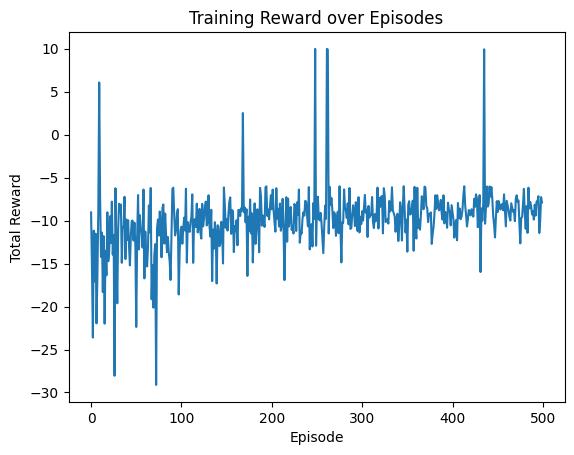

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# Docking Environment
class SpaceDockingEnv(gym.Env):
    def __init__(self):
        super(SpaceDockingEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(4)  # up, down, left, right, thrust
        self.observation_space = gym.spaces.Box(
            low=np.array([-1, -1, -1, -1]),
            high=np.array([1, 1, 1, 1]),
            dtype=np.float32
        )
        self.reset()

    def reset(self):
        self.agent_pos = np.array([np.random.uniform(-1, 1), np.random.uniform(-1, 1)])
        self.agent_vel = np.array([0.0, 0.0])
        self.target_pos = np.array([0.0, 0.0])
        self.fuel = 1.0
        self.done = False
        return self._get_obs()

    def _get_obs(self):
        return np.concatenate([self.agent_pos - self.target_pos, self.agent_vel])

    def step(self, action):
        if self.done:
            return self._get_obs(), 0, True, {}

        force = 0.05
        if self.fuel <= 0:
            thrust = np.array([0.0, 0.0])
        else:
            if action == 0: thrust = np.array([0, force])  # action: up
            elif action == 1: thrust = np.array([0, -force])  # action: down
            elif action == 2: thrust = np.array([-force, 0])  # action: left
            elif action == 3: thrust = np.array([force, 0])  # action: right
            else: thrust = np.array([0.0, 0.0])
            self.fuel -= 0.01

        self.agent_vel += thrust
        self.agent_pos += self.agent_vel

        dist = np.linalg.norm(self.agent_pos - self.target_pos)
        reward = -dist

        if dist < 0.05:
            reward += 10
            self.done = True

        if np.any(np.abs(self.agent_pos) > 1.0):
            self.done = True
            reward -= 5

        return self._get_obs(), reward, self.done, {}

    def render(self):
        print(f"Position: {self.agent_pos}, Velocity: {self.agent_vel}, Fuel: {self.fuel}")

# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def _build_model(self):
        return nn.Sequential(
            nn.Linear(self.state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, self.action_size)
        )

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            act_values = self.model(state_tensor)
        return torch.argmax(act_values).item()

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * torch.max(self.model(torch.FloatTensor(next_state).unsqueeze(0))).item()
            target_f = self.model(torch.FloatTensor(state).unsqueeze(0))
            target_val = target_f.clone()
            target_val[0][action] = target
            self.optimizer.zero_grad()
            loss = self.criterion(target_f, target_val)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Training Loop
if __name__ == "__main__":
    env = SpaceDockingEnv()
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    episodes = 500
    batch_size = 32
    rewards = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        for time_t in range(200):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                print(f"Episode {e+1}/{episodes}, Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
                break
        rewards.append(total_reward)
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

    # Plotting
    plt.plot(rewards)
    plt.title("Training Reward over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.show()
